In [3]:
#!/usr/bin/env python3
"""
MacOS Environment Debugging Script for Protein Graph Machine Learning
This script checks GPU availability, DSSP installation, PyTorch configuration and
other environment variables critical for running Graphein and protein structure analysis.
"""

import sys
import os
import platform
import subprocess
from datetime import datetime
import shutil
import warnings

# Suppress specific warnings that might clutter the output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def print_header(title):
    """Print a formatted section header"""
    print("\n" + "="*80)
    print(f" {title} ".center(80, "="))
    print("="*80)

def run_command(command, check=False):
    """Run a shell command and return the output"""
    try:
        result = subprocess.run(
            command,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            check=check,
            shell=True
        )
        return result.stdout.strip(), result.stderr.strip(), result.returncode
    except Exception as e:
        return "", str(e), 1

def check_command_exists(command):
    """Check if a command exists in the system PATH"""
    return shutil.which(command) is not None

def main():
    print_header("SYSTEM INFORMATION")
    print(f"Date and time: {datetime.now()}")
    print(f"Python version: {sys.version}")
    print(f"Python executable: {sys.executable}")
    print(f"Platform: {platform.platform()}")
    print(f"macOS version: {platform.mac_ver()[0]}")
    print(f"Processor: {platform.processor()}")
    print(f"Machine: {platform.machine()}")

    # Check if running on Apple Silicon or Intel
    is_apple_silicon = platform.machine() == "arm64"
    print(f"Apple Silicon: {is_apple_silicon}")

    # Check if we're in a virtual environment
    in_venv = sys.prefix != sys.base_prefix
    print(f"Running in virtual environment: {in_venv}")

    print_header("GPU AVAILABILITY")

    # Check for Metal (Apple's GPU framework)
    metal_check, metal_err, _ = run_command("system_profiler SPDisplaysDataType")
    if "Graphics" in metal_check:
        print("Metal Graphics Info:")
        for line in metal_check.split('\n'):
            if any(term in line for term in ["Graphics", "VRAM", "Metal", "GPU", "Vendor"]):
                print(f"  {line.strip()}")
    else:
        print("Could not detect Metal graphics information")

    # PyTorch and CUDA Information
    print_header("PYTORCH & GPU FRAMEWORKS")
    try:
        import torch
        print(f"PyTorch version: {torch.__version__}")

        # Check if MPS (Metal Performance Shaders) is available for Apple Silicon
        mps_available = hasattr(torch, 'mps') and hasattr(torch.mps, 'is_available')
        if mps_available:
            print(f"MPS (Metal) available: {torch.mps.is_available()}")
            if torch.mps.is_available():
                print("PyTorch can use Metal for GPU acceleration")

        # Check CUDA availability (less common on Mac but possible)
        print(f"CUDA available: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"CUDA version: {torch.version.cuda}")
            print(f"Number of CUDA devices: {torch.cuda.device_count()}")
            for i in range(torch.cuda.device_count()):
                print(f"CUDA device {i}: {torch.cuda.get_device_name(i)}")
            print(f"Current CUDA device: {torch.cuda.current_device()}")
    except ImportError:
        print("PyTorch is not installed")
    except Exception as e:
        print(f"Error checking PyTorch configuration: {e}")

    # Graphein Installation Check
    print_header("GRAPHEIN INSTALLATION")
    try:
        import graphein
        print(f"Graphein version: {graphein.__version__}")

        # Import key graphein modules to verify they work
        from graphein.protein.config import ProteinGraphConfig
        from graphein.protein.graphs import construct_graph

        print("Successfully imported key Graphein modules")
    except ImportError:
        print("Graphein is not installed or there's an import error")
    except Exception as e:
        print(f"Error when importing Graphein: {e}")

    # Check Installed Packages
    print_header("KEY PACKAGES")
    import pkg_resources

    # Show key packages
    key_packages = ["graphein", "torch", "numpy", "pandas", "biopython",
                   "networkx", "scipy", "biotite", "pyparsing", "requests"]
    for pkg in key_packages:
        try:
            version = pkg_resources.get_distribution(pkg).version
            print(f"{pkg}: {version}")
        except pkg_resources.DistributionNotFound:
            print(f"{pkg}: Not installed")

    # DSSP Availability Check
    print_header("DSSP AVAILABILITY")

    # Check if DSSP is available through Homebrew or other installation
    dssp_available = check_command_exists("dssp")
    print(f"DSSP command available: {dssp_available}")

    # Check for mkdssp (newer name for DSSP)
    mkdssp_available = check_command_exists("mkdssp")
    print(f"mkdssp command available: {mkdssp_available}")

    # Try to locate DSSP
    if dssp_available:
        dssp_path, _, _ = run_command("which dssp")
        print(f"DSSP located at: {dssp_path}")

        # Try to get DSSP version
        dssp_version, dssp_err, _ = run_command("dssp --version")
        if dssp_version:
            print(f"DSSP version: {dssp_version}")
        else:
            print(f"Could not get DSSP version. Error: {dssp_err}")

    # Try to locate mkdssp
    if mkdssp_available:
        mkdssp_path, _, _ = run_command("which mkdssp")
        print(f"mkdssp located at: {mkdssp_path}")

        # Try to get mkdssp version
        mkdssp_version, mkdssp_err, _ = run_command("mkdssp --version")
        if mkdssp_version:
            print(f"mkdssp version: {mkdssp_version}")
        else:
            print(f"Could not get mkdssp version. Error: {mkdssp_err}")

    # Homebrew check (for DSSP installation if needed)
    homebrew_exists = check_command_exists("brew")
    print(f"Homebrew installed: {homebrew_exists}")

    if not dssp_available and not mkdssp_available:
        print("\nDSSP not found. To install with Homebrew, try: brew install brewsci/bio/dssp")

    # Check if environment variables are set for DSSP
    dssp_env = os.environ.get("DSSP_PATH", "Not set")
    print(f"DSSP_PATH environment variable: {dssp_env}")

    # Try to configure DSSP for Graphein if installed
    if dssp_available or mkdssp_available:
        print_header("GRAPHEIN DSSP CONFIGURATION")

        try:
            # Import the correct DSSP function for Graphein
            from graphein.protein.features.nodes.dssp import add_dssp_feature
            print("Successfully imported DSSP feature from Graphein")

            # Set DSSP path if not already set
            if dssp_available and dssp_path:
                if "DSSP_PATH" not in os.environ:
                    os.environ["DSSP_PATH"] = dssp_path
                    print(f"Set DSSP_PATH to: {dssp_path}")
            elif mkdssp_available and mkdssp_path:
                if "DSSP_PATH" not in os.environ:
                    os.environ["DSSP_PATH"] = mkdssp_path
                    print(f"Set DSSP_PATH to: {mkdssp_path}")

            # Example configuration to use DSSP
            config = ProteinGraphConfig()
            config.node_metadata_functions = [add_dssp_feature]
            print("Successfully configured Graphein to use DSSP")

        except ImportError as e:
            print(f"Could not import DSSP feature from Graphein: {e}")
        except Exception as e:
            print(f"Error setting up DSSP: {e}")

    print_header("VERIFICATION TESTS")

    # Test if we can create a simple PyTorch tensor and move it to GPU if available
    try:
        import torch
        print("Creating test PyTorch tensor...")
        test_tensor = torch.tensor([1.0, 2.0, 3.0])
        print(f"Default tensor device: {test_tensor.device}")

        # Test MPS if available
        if hasattr(torch, 'mps') and torch.mps.is_available():
            try:
                mps_device = torch.device("mps")
                mps_tensor = test_tensor.to(mps_device)
                print(f"Successfully moved tensor to MPS device: {mps_tensor.device}")
            except Exception as e:
                print(f"Error moving tensor to MPS device: {e}")

        # Test CUDA if available
        if torch.cuda.is_available():
            try:
                cuda_tensor = test_tensor.to("cuda")
                print(f"Successfully moved tensor to CUDA device: {cuda_tensor.device}")
            except Exception as e:
                print(f"Error moving tensor to CUDA device: {e}")
    except ImportError:
        print("PyTorch not available for testing")
    except Exception as e:
        print(f"Error testing PyTorch tensor operations: {e}")

    # Test simple PDB loading with Graphein if available
    try:
        from graphein.protein.config import ProteinGraphConfig
        from graphein.protein.graphs import construct_graph
        from graphein.protein.utils import download_pdb
        import tempfile

        print("\nTesting PDB file download and parsing...")
        with tempfile.TemporaryDirectory() as tmpdir:
            # Try to download a small test PDB file (1BDD - a small protein)
            pdb_code = "1BDD"
            pdb_path = os.path.join(tmpdir, f"{pdb_code}.pdb")

            try:
                download_success = download_pdb(pdb_code, out_dir=tmpdir)
                if download_success:
                    print(f"Successfully downloaded PDB file for {pdb_code}")

                    # Create a minimal configuration
                    config = ProteinGraphConfig()

                    # Try to construct a graph
                    try:
                        graph = construct_graph(path=pdb_path, config=config)
                        print(f"Successfully constructed graph with {len(graph.nodes)} nodes and {len(graph.edges)} edges")
                    except Exception as e:
                        print(f"Error constructing graph: {e}")
                else:
                    print(f"Failed to download PDB file for {pdb_code}")
            except Exception as e:
                print(f"Error downloading PDB file: {e}")
    except ImportError:
        print("Graphein not available for testing PDB parsing")
    except Exception as e:
        print(f"Error in PDB parsing test: {e}")

    print_header("RECOMMENDATIONS")

    if not dssp_available and not mkdssp_available:
        print("- Install DSSP using: brew install brewsci/bio/dssp")

    if is_apple_silicon and not (hasattr(torch, 'mps') and torch.mps.is_available()):
        print("- For Apple Silicon Macs, install PyTorch with MPS support:")
        print("  pip install --upgrade torch")

    if not is_apple_silicon and not torch.cuda.is_available():
        print("- PyTorch CUDA support not detected.")
        print("  If you have an NVIDIA GPU, ensure CUDA toolkit and cuDNN are installed.")

    print("\nCompleted environment diagnostics.")

if __name__ == "__main__":
    main()


============================== SYSTEM INFORMATION ==============================
Date and time: 2025-03-26 11:24:42.932835
Python version: 3.9.6 (default, Nov 11 2024, 03:15:38) 
[Clang 16.0.0 (clang-1600.0.26.6)]
Python executable: /Users/alexchilton/PycharmProjects/final_try/.venv/bin/python
Platform: macOS-15.3.2-arm64-arm-64bit
macOS version: 15.3.2
Processor: arm
Machine: arm64
Apple Silicon: True
Running in virtual environment: True

=============================== GPU AVAILABILITY ===============================
Metal Graphics Info:
  Graphics/Displays:
  Type: GPU
  Vendor: Apple (0x106b)
  Metal Support: Metal 3

=========================== PYTORCH & GPU FRAMEWORKS ===========================
PyTorch version: 1.11.0
CUDA available: False

============================ GRAPHEIN INSTALLATION =============================
Graphein version: 1.7.7


/Users/alexchilton/PycharmProjects/final_try/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Successfully imported key Graphein modules

================================= KEY PACKAGES =================================
graphein: 1.7.7
torch: 1.11.0
numpy: 1.26.4
pandas: 2.2.3
biopython: 1.85
networkx: 3.2.1
scipy: 1.13.1
biotite: Not installed
pyparsing: 3.2.1
requests: 2.32.3

============================== DSSP AVAILABILITY ===============================
DSSP command available: False
mkdssp command available: True
mkdssp located at: /opt/homebrew/bin/mkdssp
mkdssp version: mkdssp version 4.4.10
Homebrew installed: True
DSSP_PATH environment variable: Not set

========================= GRAPHEIN DSSP CONFIGURATION ==========================
Successfully imported DSSP feature from Graphein
Set DSSP_PATH to: /opt/homebrew/bin/mkdssp
Successfully configured Graphein to use DSSP

============================== VERIFICATION TESTS ==============================
Creating test PyTorch tensor...
Default tensor device: cpu

Testing PDB file download and parsing...


Output()

Successfully downloaded PDB file for 1BDD


Successfully constructed graph with 60 nodes and 59 edges

=============================== RECOMMENDATIONS ================================
- For Apple Silicon Macs, install PyTorch with MPS support:
  pip install --upgrade torch

Completed environment diagnostics.


In [4]:
import os
from graphein.protein.config import ProteinGraphConfig, DSSPConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.features.nodes.dssp import add_dssp_df
from graphein.protein.utils import download_pdb

# Set DSSP path environment variable
os.environ["DSSP_PATH"] = "/opt/homebrew/bin/mkdssp"
print(f"DSSP_PATH set to: {os.environ['DSSP_PATH']}")

# Create a DSSP config with no parameters
dssp_config = DSSPConfig()
print("Created DSSPConfig object")

# Download the PDB file
pdb_code = "1BDD"
pdb_path = download_pdb(pdb_code, out_dir="./")
print(f"Downloaded PDB file to {pdb_path}")

# Create basic protein graph config
config = ProteinGraphConfig()
# Attach DSSP config to graph config
config.dssp_config = dssp_config
print("Created protein graph config with DSSP config")

# Construct the graph
print("Constructing graph...")
graph = construct_graph(path=pdb_path, config=config)
print(f"Graph contains {len(graph.nodes)} nodes and {len(graph.edges)} edges")

# Try to add DSSP dataframe
print("Adding DSSP dataframe...")
try:
    graph = add_dssp_df(graph, dssp_config=dssp_config)
    print("DSSP dataframe successfully added")

    # Check for DSSP dataframe in graph
    if "dssp_df" in graph.graph:
        print("Success: DSSP dataframe is in the graph")
    else:
        print("Warning: DSSP dataframe not found in graph")
except Exception as e:
    print(f"Error adding DSSP dataframe: {str(e)}")

# Print available node attributes
sample_node = list(graph.nodes)[0]
print(f"\nSample node: {sample_node}")
print("Available attributes:")
for key in graph.nodes[sample_node]:
    print(f"- {key}")

Output()

DSSP_PATH set to: /opt/homebrew/bin/mkdssp
Created DSSPConfig object
Downloaded PDB file to 1bdd.pdb
Created protein graph config with DSSP config
Constructing graph...


Graph contains 60 nodes and 59 edges
Adding DSSP dataframe...
DSSP dataframe successfully added
Success: DSSP dataframe is in the graph

Sample node: A:THR:1
Available attributes:
- chain_id
- residue_name
- residue_number
- atom_type
- element_symbol
- coords
- b_factor
- meiler


In [5]:
import os
import pandas as pd
from graphein.protein.config import ProteinGraphConfig, DSSPConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.features.nodes.dssp import add_dssp_df
from graphein.protein.utils import download_pdb

def add_secondary_structure_to_nodes(graph):
    """
    Extract secondary structure from DSSP dataframe and add to nodes.
    This is the bare minimum to test DSSP functionality.
    """
    # Check if DSSP dataframe exists
    if "dssp_df" not in graph.graph:
        print("No DSSP dataframe found in graph")
        return graph

    # Get the DSSP dataframe
    dssp_df = graph.graph["dssp_df"]

    # Check if secondary structure column exists
    if "ss" not in dssp_df.columns:
        print(f"No 'ss' column found in DSSP dataframe. Available columns: {dssp_df.columns}")
        return graph

    # Count how many nodes were updated
    updated_count = 0

    # Add secondary structure to each node
    for node, data in graph.nodes(data=True):
        # Extract chain and residue info from node ID
        parts = str(node).split(':')
        if len(parts) >= 3:
            chain = parts[0]
            residue_num = parts[2]

            # Try to find matching row in DSSP dataframe
            try:
                # Different versions of Graphein might have different column names
                if 'chain_id' in dssp_df.columns and 'residue_number' in dssp_df.columns:
                    mask = (dssp_df['chain_id'] == chain) & (dssp_df['residue_number'] == int(residue_num))
                elif 'chain' in dssp_df.columns and 'resnum' in dssp_df.columns:
                    mask = (dssp_df['chain'] == chain) & (dssp_df['resnum'] == int(residue_num))
                else:
                    # Try to guess based on available columns
                    chain_col = next((col for col in dssp_df.columns if 'chain' in col.lower()), None)
                    res_col = next((col for col in dssp_df.columns if 'res' in col.lower() and 'num' in col.lower()), None)

                    if chain_col and res_col:
                        mask = (dssp_df[chain_col] == chain) & (dssp_df[res_col] == int(residue_num))
                    else:
                        continue

                # If we found a matching row, add the SS value
                matching_rows = dssp_df[mask]
                if not matching_rows.empty:
                    data['ss_value'] = matching_rows['ss'].values[0]
                    updated_count += 1
            except (ValueError, KeyError) as e:
                # Skip this node if there are issues
                continue

    print(f"Added secondary structure to {updated_count} out of {len(graph.nodes)} nodes")
    return graph

# Main function to test everything
def test_dssp_minimal():
    # Set DSSP path
    os.environ["DSSP_PATH"] = "/opt/homebrew/bin/mkdssp"

    # Download PDB and create graph
    pdb_code = "1BDD"
    pdb_path = download_pdb(pdb_code, out_dir="./")

    # Configure graph with DSSP
    config = ProteinGraphConfig()
    config.dssp_config = DSSPConfig()

    # Construct graph
    graph = construct_graph(path=pdb_path, config=config)

    # Add DSSP dataframe
    graph = add_dssp_df(graph, dssp_config=config.dssp_config)

    # Add secondary structure to nodes
    graph = add_secondary_structure_to_nodes(graph)

    # Check results
    has_ss = any('ss_value' in graph.nodes[node] for node in graph.nodes)
    print(f"Secondary structure found in nodes: {'Yes' if has_ss else 'No'}")

    if has_ss:
        # Get a node with secondary structure
        ss_node = next((node for node in graph.nodes if 'ss_value' in graph.nodes[node]), None)
        if ss_node:
            print(f"Example node {ss_node} has secondary structure: {graph.nodes[ss_node]['ss_value']}")

            # Count by secondary structure type
            ss_types = {}
            for node in graph.nodes:
                if 'ss_value' in graph.nodes[node]:
                    ss = graph.nodes[node]['ss_value']
                    ss_types[ss] = ss_types.get(ss, 0) + 1

            print("Secondary structure distribution:")
            for ss, count in ss_types.items():
                print(f"  {ss}: {count} residues")

    return graph

# Run the test
result = test_dssp_minimal()

Output()

Added secondary structure to 60 out of 60 nodes
Secondary structure found in nodes: Yes
Example node A:THR:1 has secondary structure: -
Secondary structure distribution:
  -: 12 residues
  S: 6 residues
  H: 36 residues
  T: 6 residues


Output()

Using DSSP at: /opt/homebrew/bin/mkdssp
Downloaded to 1ubq.pdb
Created protein graph configuration with DSSP
Constructing protein graph...


Graph contains 76 nodes and 75 edges
Adding DSSP dataframe...
DSSP dataframe successfully added to graph
DSSP dataframe shape: (76, 17)
DSSP dataframe columns: ['chain', 'resnum', 'icode', 'aa', 'ss', 'asa', 'phi', 'psi', 'dssp_index', 'NH_O_1_relidx', 'NH_O_1_energy', 'O_NH_1_relidx', 'O_NH_1_energy', 'NH_O_2_relidx', 'NH_O_2_energy', 'O_NH_2_relidx', 'O_NH_2_energy']
Adding DSSP features to nodes...
Available DSSP features: ['chain', 'resnum', 'icode', 'aa', 'ss', 'asa', 'phi', 'psi', 'dssp_index', 'NH_O_1_relidx', 'NH_O_1_energy', 'O_NH_1_relidx', 'O_NH_1_energy', 'NH_O_2_relidx', 'NH_O_2_energy', 'O_NH_2_relidx', 'O_NH_2_energy']
Found 13 DSSP features in the dataframe
Using 'chain' for chain ID and 'resnum' for residue number
Updated 76 out of 76 nodes
Added the following features to nodes: ['dssp_aa', 'dssp_index', 'nh_o1_energy', 'nh_o1_relidx', 'nh_o2_energy', 'nh_o2_relidx', 'o_nh1_energy', 'o_nh1_relidx', 'o_nh2_energy', 'o_nh2_relidx', 'phi', 'psi', 'ss_value']

=== Secondar

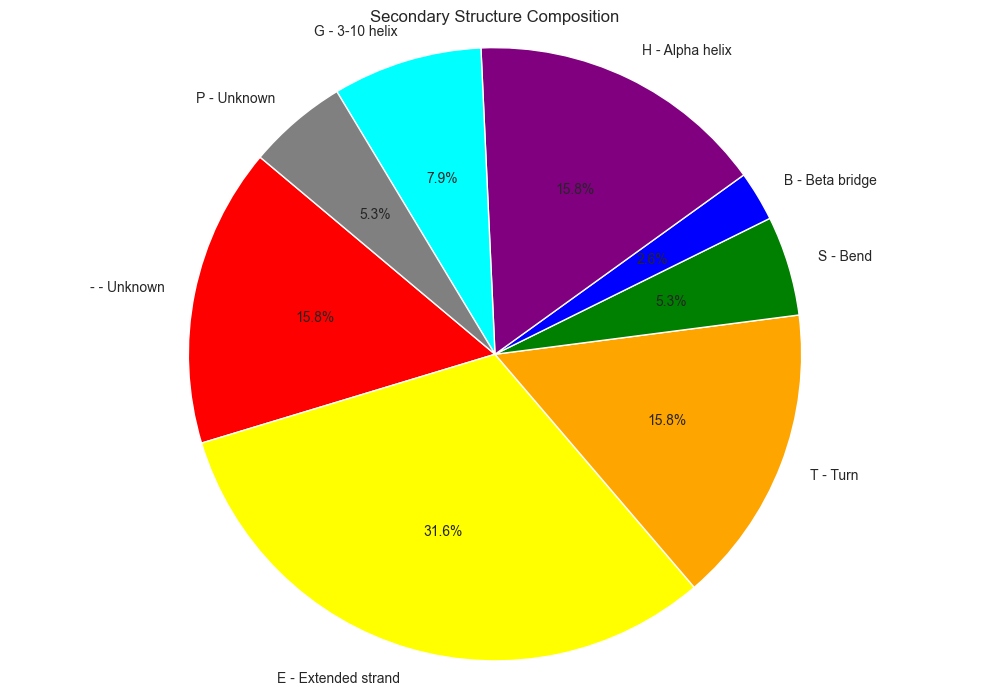


=== Ramachandran Plot ===


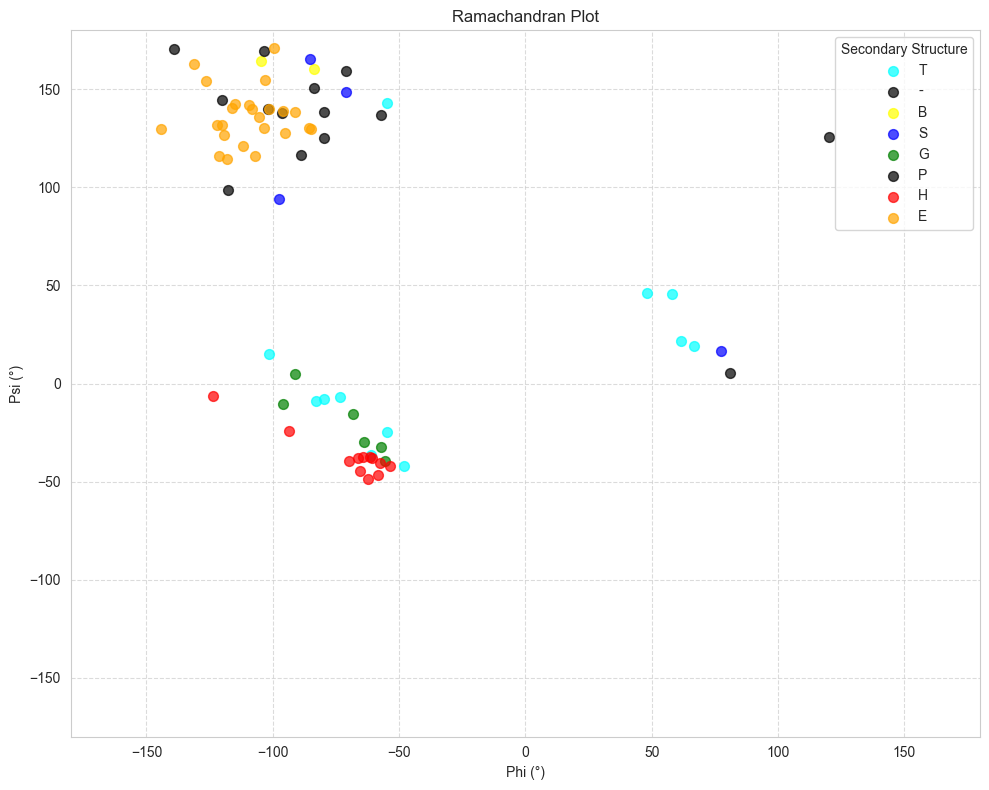


=== Solvent Accessibility Analysis ===
No solvent accessibility information found in the graph

=== Hydrogen Bond Analysis ===


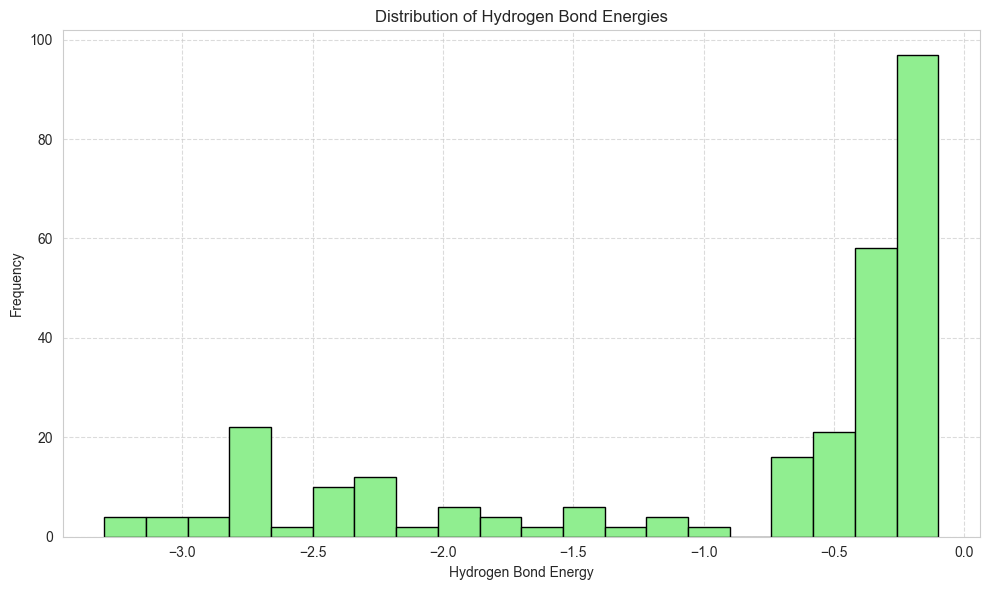

Hydrogen Bond Statistics:
Number of hydrogen bonds: 278
Average energy: -0.91
Minimum energy: -3.30
Maximum energy: -0.10

=== Visualizing Protein Structure ===


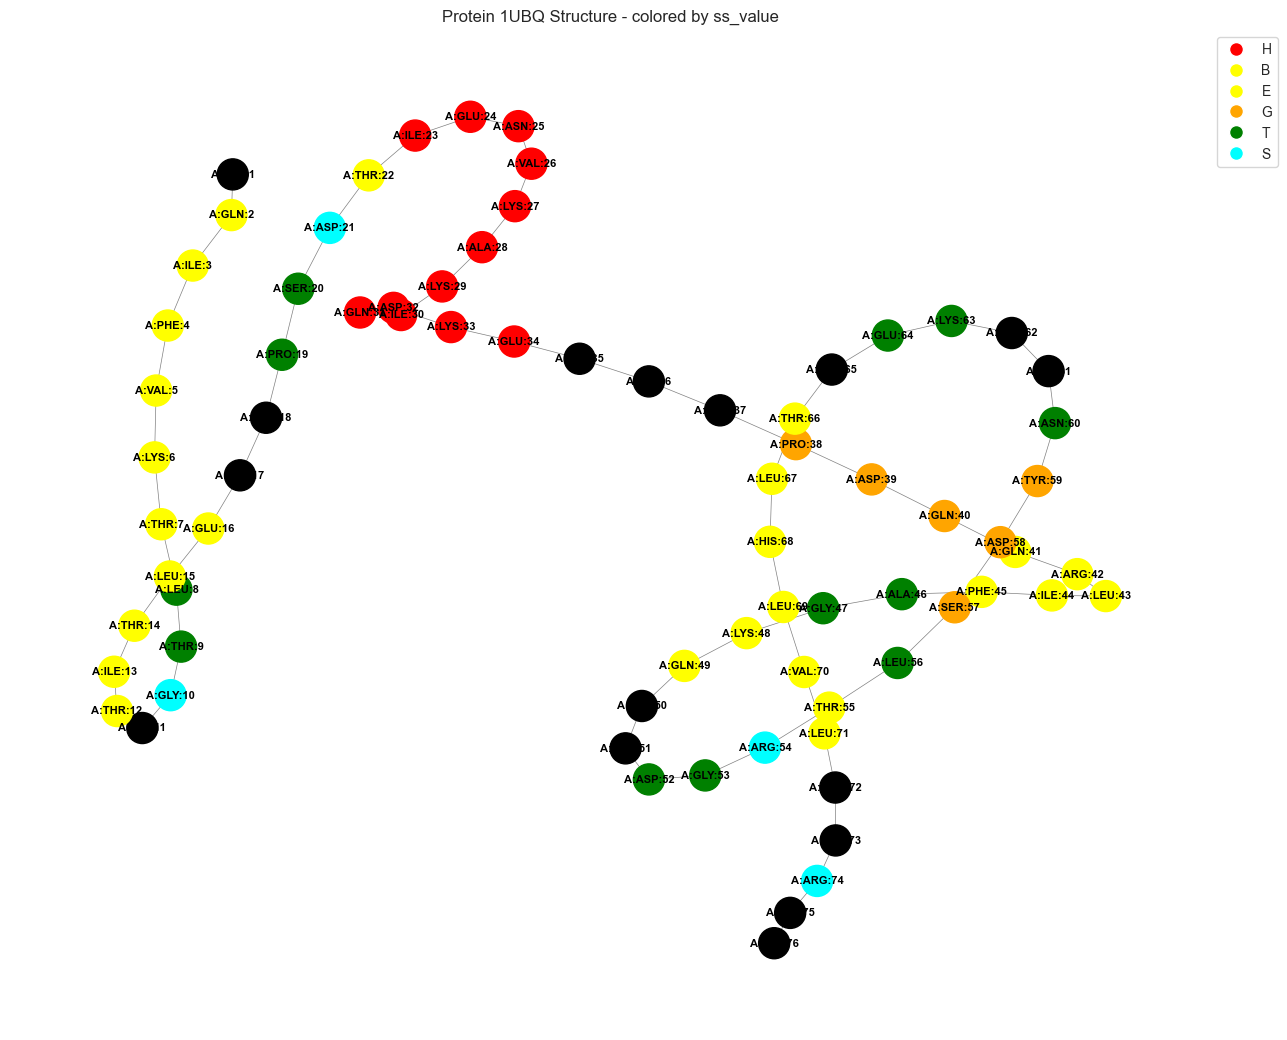


Comprehensive DSSP analysis complete!


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from graphein.protein.config import ProteinGraphConfig, DSSPConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.features.nodes.dssp import add_dssp_df
from graphein.protein.utils import download_pdb

def add_all_dssp_features_to_nodes(graph):
    """
    Extract all available DSSP features from the dataframe and add them to nodes.
    """
    if "dssp_df" not in graph.graph:
        print("No DSSP dataframe found in graph")
        return graph

    # Get the DSSP dataframe
    dssp_df = graph.graph["dssp_df"]

    # Print available columns in DSSP dataframe
    print(f"Available DSSP features: {list(dssp_df.columns)}")

    # Map of common DSSP column names and their descriptions
    dssp_features = {
        'ss': 'Secondary structure (ss_value)',
        'aa': 'Amino acid (dssp_aa)',
        'acc': 'Absolute solvent accessibility (acc)',
        'phi': 'Phi angle (phi)',
        'psi': 'Psi angle (psi)',
        'dssp_index': 'DSSP residue index (dssp_index)',
        'NH_O_1_relidx': 'First NH-O hydrogen bond relative index (nh_o1_relidx)',
        'NH_O_1_energy': 'First NH-O hydrogen bond energy (nh_o1_energy)',
        'O_NH_1_relidx': 'First O-NH hydrogen bond relative index (o_nh1_relidx)',
        'O_NH_1_energy': 'First O-NH hydrogen bond energy (o_nh1_energy)',
        'NH_O_2_relidx': 'Second NH-O hydrogen bond relative index (nh_o2_relidx)',
        'NH_O_2_energy': 'Second NH-O hydrogen bond energy (nh_o2_energy)',
        'O_NH_2_relidx': 'Second O-NH hydrogen bond relative index (o_nh2_relidx)',
        'O_NH_2_energy': 'Second O-NH hydrogen bond energy (o_nh2_energy)',
    }

    # Variation in column naming across different versions
    alt_column_names = {
        'ss': ['ss', 'SS', 'sec_struc'],
        'aa': ['aa', 'AA', 'amino_acid'],
        'acc': ['acc', 'ACC', 'accessibility'],
        'phi': ['phi', 'PHI'],
        'psi': ['psi', 'PSI'],
        'dssp_index': ['dssp_index', 'id'],
        'NH_O_1_relidx': ['NH_O_1_relidx', 'NH-O_1_relidx', 'NH_O_1_ridx'],
        'NH_O_1_energy': ['NH_O_1_energy', 'NH-O_1_energy'],
        'O_NH_1_relidx': ['O_NH_1_relidx', 'O-NH_1_relidx', 'O_NH_1_ridx'],
        'O_NH_1_energy': ['O_NH_1_energy', 'O-NH_1_energy'],
        'NH_O_2_relidx': ['NH_O_2_relidx', 'NH-O_2_relidx', 'NH_O_2_ridx'],
        'NH_O_2_energy': ['NH_O_2_energy', 'NH-O_2_energy'],
        'O_NH_2_relidx': ['O_NH_2_relidx', 'O-NH_2_relidx', 'O_NH_2_ridx'],
        'O_NH_2_energy': ['O_NH_2_energy', 'O-NH_2_energy'],
    }

    # Find the actual column names in the dataframe
    actual_columns = {}
    for feature, alternatives in alt_column_names.items():
        for alt in alternatives:
            if alt in dssp_df.columns:
                actual_columns[feature] = alt
                break

    print(f"Found {len(actual_columns)} DSSP features in the dataframe")

    # Track how many nodes were updated
    updated_nodes = 0
    features_added = set()

    # Different versions of Graphein might have different column names for chain & residue
    # Try to identify the correct column names
    chain_col = next((c for c in dssp_df.columns if 'chain' in c.lower()), None)
    res_num_col = next((c for c in dssp_df.columns if 'res' in c.lower() and 'num' in c.lower()), None)

    if not chain_col or not res_num_col:
        print(f"Could not identify chain and residue number columns in DSSP dataframe")
        print(f"Available columns: {dssp_df.columns}")
        return graph

    print(f"Using '{chain_col}' for chain ID and '{res_num_col}' for residue number")

    # Add features to each node
    for node, data in graph.nodes(data=True):
        # Extract chain and residue info from node ID
        parts = str(node).split(':')
        if len(parts) < 3:
            continue

        chain = parts[0]
        residue_num = parts[2]

        try:
            # Find matching row in DSSP dataframe
            mask = (dssp_df[chain_col] == chain) & (dssp_df[res_num_col] == int(residue_num))
            matching_rows = dssp_df[mask]

            if matching_rows.empty:
                continue

            # Add all available features to the node
            for feature, col_name in actual_columns.items():
                # Get the node attribute name from feature descriptions
                node_attr = dssp_features[feature].split('(')[1].split(')')[0] if '(' in dssp_features[feature] else feature

                # Add the feature to the node
                if col_name in matching_rows.columns:
                    data[node_attr] = matching_rows[col_name].values[0]
                    features_added.add(node_attr)

            updated_nodes += 1

        except (ValueError, KeyError) as e:
            # Skip this node if there are issues
            continue

    print(f"Updated {updated_nodes} out of {len(graph.nodes)} nodes")
    print(f"Added the following features to nodes: {sorted(list(features_added))}")

    return graph

def visualize_protein_structure(graph, feature='ss_value', title='Protein Structure Visualization', figsize=(12, 10)):
    """
    Visualize the protein structure with nodes colored by a selected DSSP feature.
    """
    # Check if the feature exists in the graph
    has_feature = any(feature in graph.nodes[node] for node in graph.nodes)
    if not has_feature:
        print(f"Feature '{feature}' not found in graph nodes")
        return

    # Create a subgraph for visualization (limit to first 100 nodes for clarity)
    node_list = list(graph.nodes)[:100]
    subgraph = graph.subgraph(node_list)

    # Setup colors for secondary structure
    if feature == 'ss_value':
        # Define colors for each secondary structure type
        ss_colors = {
            'H': 'red',       # Alpha helix
            'B': 'yellow',    # Beta bridge
            'E': 'yellow',    # Extended strand
            'G': 'orange',    # 3-10 helix
            'I': 'pink',      # Pi helix
            'T': 'green',     # Turn
            'S': 'cyan',      # Bend
            ' ': 'grey',      # Loop/irregular
        }

        # Assign colors to nodes
        node_colors = []
        for node in subgraph.nodes:
            if feature in subgraph.nodes[node]:
                node_colors.append(ss_colors.get(subgraph.nodes[node][feature], 'black'))
            else:
                node_colors.append('black')

        # Create a legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                      markerfacecolor=color, markersize=10, label=struct)
                           for struct, color in ss_colors.items() if any(subgraph.nodes[node].get(feature) == struct for node in subgraph.nodes)]
    else:
        # For numerical features, use a colormap
        values = [subgraph.nodes[node].get(feature, np.nan) for node in subgraph.nodes]
        if all(isinstance(v, (int, float)) for v in values if v is not np.nan):
            # Use a colormap for numerical values
            node_colors = values
            cmap = plt.cm.viridis
            vmin, vmax = np.nanmin(values), np.nanmax(values)
            legend_elements = None
        else:
            # For categorical features, assign unique colors
            unique_values = set(v for v in values if v is not np.nan)
            value_colors = {val: plt.cm.tab10(i/10) for i, val in enumerate(unique_values)}
            node_colors = [value_colors.get(val, (0,0,0,1)) for val in values]
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                          markerfacecolor=color, markersize=10, label=val)
                               for val, color in value_colors.items()]

    # Create the figure
    plt.figure(figsize=figsize)

    # Compute node positions (use spring layout for better visualization)
    pos = nx.spring_layout(subgraph, seed=42)

    # Draw the graph
    nx.draw(subgraph, pos,
            node_color=node_colors,
            with_labels=True,
            node_size=500,
            font_size=8,
            font_weight='bold',
            edge_color='gray',
            width=0.5)

    # Add a title
    plt.title(f"{title} - colored by {feature}")

    # Add a legend if applicable
    if legend_elements:
        plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

def analyze_secondary_structure(graph):
    """
    Analyze the secondary structure composition of the protein.
    """
    # Check if secondary structure is available
    has_ss = any('ss_value' in graph.nodes[node] for node in graph.nodes)
    if not has_ss:
        print("No secondary structure information found in the graph")
        return

    # Collect secondary structure information
    ss_values = []
    for node in graph.nodes:
        if 'ss_value' in graph.nodes[node]:
            ss_values.append(graph.nodes[node]['ss_value'])

    # Count occurrences of each secondary structure type
    ss_counts = {}
    for ss in ss_values:
        ss_counts[ss] = ss_counts.get(ss, 0) + 1

    # Define secondary structure meanings
    ss_meaning = {
        'H': 'Alpha helix',
        'B': 'Beta bridge',
        'E': 'Extended strand',
        'G': '3-10 helix',
        'I': 'Pi helix',
        'T': 'Turn',
        'S': 'Bend',
        ' ': 'Loop/irregular'
    }

    # Print distribution
    print("Secondary Structure Distribution:")
    for ss, count in sorted(ss_counts.items()):
        percentage = (count / len(ss_values)) * 100
        meaning = ss_meaning.get(ss, 'Unknown')
        print(f"{ss} ({meaning}): {count} residues ({percentage:.1f}%)")

    # Create a pie chart
    plt.figure(figsize=(10, 7))
    labels = [f"{ss} - {ss_meaning.get(ss, 'Unknown')}" for ss in ss_counts.keys()]
    sizes = list(ss_counts.values())
    colors = ['red', 'yellow', 'orange', 'green', 'blue', 'purple', 'cyan', 'grey'][:len(ss_counts)]

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Secondary Structure Composition')
    plt.tight_layout()
    plt.show()

def analyze_ramachandran(graph):
    """
    Create a Ramachandran plot using phi/psi angles from DSSP.
    """
    # Check if phi/psi angles are available
    has_angles = any('phi' in graph.nodes[node] and 'psi' in graph.nodes[node] for node in graph.nodes)
    if not has_angles:
        print("No phi/psi angle information found in the graph")
        return

    # Collect phi/psi angles and secondary structure
    phi_values = []
    psi_values = []
    ss_values = []

    for node in graph.nodes:
        if 'phi' in graph.nodes[node] and 'psi' in graph.nodes[node]:
            phi = graph.nodes[node]['phi']
            psi = graph.nodes[node]['psi']

            # Skip if angles are not numeric
            if not isinstance(phi, (int, float)) or not isinstance(psi, (int, float)):
                continue

            phi_values.append(phi)
            psi_values.append(psi)

            # Add secondary structure if available
            if 'ss_value' in graph.nodes[node]:
                ss_values.append(graph.nodes[node]['ss_value'])
            else:
                ss_values.append(None)

    # Create a Ramachandran plot
    plt.figure(figsize=(10, 8))

    # If we have secondary structure, color by type
    if ss_values and any(ss is not None for ss in ss_values):
        # Define colors for each secondary structure type
        ss_colors = {
            'H': 'red',       # Alpha helix
            'B': 'yellow',    # Beta bridge
            'E': 'orange',    # Extended strand
            'G': 'green',     # 3-10 helix
            'I': 'pink',      # Pi helix
            'T': 'cyan',      # Turn
            'S': 'blue',      # Bend
            ' ': 'grey',      # Loop/irregular
            None: 'black'     # Unknown
        }

        # Create scatter plot with colored points
        for ss_type in set(ss_values):
            indices = [i for i, ss in enumerate(ss_values) if ss == ss_type]
            if indices:
                plt.scatter(
                    [phi_values[i] for i in indices],
                    [psi_values[i] for i in indices],
                    c=ss_colors.get(ss_type, 'black'),
                    label=f"{ss_type}" if ss_type else "Unknown",
                    alpha=0.7,
                    s=50
                )
    else:
        # Simple scatter plot without coloring
        plt.scatter(phi_values, psi_values, c='blue', alpha=0.5)

    # Add grid lines and labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Phi (°)')
    plt.ylabel('Psi (°)')
    plt.title('Ramachandran Plot')

    # Set limits to show relevant angles
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)

    # Add legend if we have secondary structure information
    if ss_values and any(ss is not None for ss in ss_values):
        plt.legend(title="Secondary Structure")

    plt.tight_layout()
    plt.show()

def analyze_solvent_accessibility(graph):
    """
    Analyze solvent accessibility from DSSP data.
    """
    # Check if accessibility data is available
    has_acc = any('acc' in graph.nodes[node] for node in graph.nodes)
    if not has_acc:
        print("No solvent accessibility information found in the graph")
        return

    # Collect accessibility values
    acc_values = []
    residue_names = []

    for node in graph.nodes:
        if 'acc' in graph.nodes[node]:
            acc = graph.nodes[node]['acc']
            # Skip if not numeric
            if not isinstance(acc, (int, float)):
                continue

            acc_values.append(acc)
            # Get residue name if available
            if 'residue_name' in graph.nodes[node]:
                residue_names.append(graph.nodes[node]['residue_name'])
            else:
                residue_names.append('Unknown')

    # Create histogram of accessibility values
    plt.figure(figsize=(10, 6))
    plt.hist(acc_values, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Solvent Accessibility')
    plt.ylabel('Frequency')
    plt.title('Distribution of Solvent Accessibility')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # If we have enough data, show accessibility by residue type
    if residue_names and len(set(residue_names)) > 1:
        # Group accessibility by residue type
        residue_acc = {}
        for res, acc in zip(residue_names, acc_values):
            if res not in residue_acc:
                residue_acc[res] = []
            residue_acc[res].append(acc)

        # Calculate average accessibility for each residue type
        avg_acc = {res: sum(accs)/len(accs) for res, accs in residue_acc.items() if accs}

        # Sort residues by average accessibility
        sorted_residues = sorted(avg_acc.items(), key=lambda x: x[1], reverse=True)

        # Create bar chart
        plt.figure(figsize=(12, 6))
        residues = [r[0] for r in sorted_residues]
        acc_avgs = [r[1] for r in sorted_residues]

        bars = plt.bar(residues, acc_avgs, color='lightblue', edgecolor='black')

        # Customize the plot
        plt.xlabel('Residue Type')
        plt.ylabel('Average Solvent Accessibility')
        plt.title('Average Solvent Accessibility by Residue Type')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

def analyze_hydrogen_bonds(graph):
    """
    Analyze hydrogen bonding patterns from DSSP data.
    """
    # Check if hydrogen bond data is available
    has_hbonds = any('nh_o1_energy' in graph.nodes[node] for node in graph.nodes)
    if not has_hbonds:
        print("No hydrogen bond information found in the graph")
        return

    # Collect hydrogen bond energies
    hbond_energies = []

    for node in graph.nodes:
        for hb_feature in ['nh_o1_energy', 'o_nh1_energy', 'nh_o2_energy', 'o_nh2_energy']:
            if hb_feature in graph.nodes[node]:
                energy = graph.nodes[node][hb_feature]
                # Skip if not numeric or zero
                if not isinstance(energy, (int, float)) or energy == 0:
                    continue
                hbond_energies.append(energy)

    if not hbond_energies:
        print("No valid hydrogen bond energies found")
        return

    # Create histogram of hydrogen bond energies
    plt.figure(figsize=(10, 6))
    plt.hist(hbond_energies, bins=20, color='lightgreen', edgecolor='black')
    plt.xlabel('Hydrogen Bond Energy')
    plt.ylabel('Frequency')
    plt.title('Distribution of Hydrogen Bond Energies')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Basic statistics
    print(f"Hydrogen Bond Statistics:")
    print(f"Number of hydrogen bonds: {len(hbond_energies)}")
    print(f"Average energy: {sum(hbond_energies)/len(hbond_energies):.2f}")
    print(f"Minimum energy: {min(hbond_energies):.2f}")
    print(f"Maximum energy: {max(hbond_energies):.2f}")

def comprehensive_dssp_example():
    """
    Run a comprehensive example of DSSP functionality in Graphein.
    """
    # Set DSSP path
    os.environ["DSSP_PATH"] = "/opt/homebrew/bin/mkdssp"
    print(f"Using DSSP at: {os.environ['DSSP_PATH']}")

    # Download the PDB file (using a slightly larger protein with more interesting structure)
    pdb_code = "1UBQ"  # Ubiquitin, a well-structured small protein
    print(f"Downloading protein {pdb_code}...")
    pdb_path = download_pdb(pdb_code, out_dir="./")
    print(f"Downloaded to {pdb_path}")

    # Create configuration with DSSP
    config = ProteinGraphConfig()
    config.dssp_config = DSSPConfig()
    print("Created protein graph configuration with DSSP")

    # Construct the graph
    print("Constructing protein graph...")
    graph = construct_graph(path=pdb_path, config=config)
    print(f"Graph contains {len(graph.nodes)} nodes and {len(graph.edges)} edges")

    # Add DSSP dataframe
    print("Adding DSSP dataframe...")
    graph = add_dssp_df(graph, dssp_config=config.dssp_config)

    # Check if DSSP dataframe was added
    if "dssp_df" in graph.graph:
        print("DSSP dataframe successfully added to graph")
        print(f"DSSP dataframe shape: {graph.graph['dssp_df'].shape}")
        print(f"DSSP dataframe columns: {list(graph.graph['dssp_df'].columns)}")
    else:
        print("Failed to add DSSP dataframe to graph")
        return None

    # Add all DSSP features to nodes
    print("Adding DSSP features to nodes...")
    graph = add_all_dssp_features_to_nodes(graph)

    # Run analyses
    print("\n=== Secondary Structure Analysis ===")
    analyze_secondary_structure(graph)

    print("\n=== Ramachandran Plot ===")
    analyze_ramachandran(graph)

    print("\n=== Solvent Accessibility Analysis ===")
    analyze_solvent_accessibility(graph)

    print("\n=== Hydrogen Bond Analysis ===")
    analyze_hydrogen_bonds(graph)

    print("\n=== Visualizing Protein Structure ===")
    visualize_protein_structure(graph, feature='ss_value',
                                title=f'Protein {pdb_code} Structure')

    print("\nComprehensive DSSP analysis complete!")
    return graph

# Run the comprehensive example
result = comprehensive_dssp_example()

In [14]:
import os
import pandas as pd
from graphein.protein.config import ProteinGraphConfig, DSSPConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.features.nodes.dssp import add_dssp_df
from graphein.protein.utils import download_pdb

def add_secondary_structure_to_nodes(graph):
    """
    Extract secondary structure from DSSP dataframe and add to nodes.
    This is the bare minimum to test DSSP functionality.
    """
    # Check if DSSP dataframe exists
    if "dssp_df" not in graph.graph:
        print("No DSSP dataframe found in graph")
        return graph

    # Get the DSSP dataframe
    dssp_df = graph.graph["dssp_df"]

    # Check if secondary structure column exists
    if "ss" not in dssp_df.columns:
        print(f"No 'ss' column found in DSSP dataframe. Available columns: {dssp_df.columns}")
        return graph

    # Count how many nodes were updated
    updated_count = 0

    # Add secondary structure to each node
    for node, data in graph.nodes(data=True):
        # Extract chain and residue info from node ID
        parts = str(node).split(':')
        if len(parts) >= 3:
            chain = parts[0]
            residue_num = parts[2]

            # Try to find matching row in DSSP dataframe
            try:
                # Different versions of Graphein might have different column names
                if 'chain_id' in dssp_df.columns and 'residue_number' in dssp_df.columns:
                    mask = (dssp_df['chain_id'] == chain) & (dssp_df['residue_number'] == int(residue_num))
                elif 'chain' in dssp_df.columns and 'resnum' in dssp_df.columns:
                    mask = (dssp_df['chain'] == chain) & (dssp_df['resnum'] == int(residue_num))
                else:
                    # Try to guess based on available columns
                    chain_col = next((col for col in dssp_df.columns if 'chain' in col.lower()), None)
                    res_col = next((col for col in dssp_df.columns if 'res' in col.lower() and 'num' in col.lower()), None)

                    if chain_col and res_col:
                        mask = (dssp_df[chain_col] == chain) & (dssp_df[res_col] == int(residue_num))
                    else:
                        continue

                # If we found a matching row, add the SS value
                matching_rows = dssp_df[mask]
                if not matching_rows.empty:
                    data['ss_value'] = matching_rows['ss'].values[0]
                    updated_count += 1
            except (ValueError, KeyError) as e:
                # Skip this node if there are issues
                continue

    print(f"Added secondary structure to {updated_count} out of {len(graph.nodes)} nodes")
    return graph

# Main function to test everything
def test_dssp_minimal():
    # Set DSSP path
    os.environ["DSSP_PATH"] = "/opt/homebrew/bin/mkdssp"

    # Download PDB and create graph
    pdb_code = "1BDD"
    pdb_path = download_pdb(pdb_code, out_dir="./")

    # Configure graph with DSSP
    config = ProteinGraphConfig()
    config.dssp_config = DSSPConfig()

    # Construct graph
    graph = construct_graph(path="1bdd.pdb", config=config)

    # Add DSSP dataframe
    graph = add_dssp_df(graph, dssp_config=config.dssp_config)

    # Add secondary structure to nodes
    graph = add_secondary_structure_to_nodes(graph)

    # Check results
    has_ss = any('ss_value' in graph.nodes[node] for node in graph.nodes)
    print(f"Secondary structure found in nodes: {'Yes' if has_ss else 'No'}")

    if has_ss:
        # Get a node with secondary structure
        ss_node = next((node for node in graph.nodes if 'ss_value' in graph.nodes[node]), None)
        if ss_node:
            print(f"Example node {ss_node} has secondary structure: {graph.nodes[ss_node]['ss_value']}")

            # Count by secondary structure type
            ss_types = {}
            for node in graph.nodes:
                if 'ss_value' in graph.nodes[node]:
                    ss = graph.nodes[node]['ss_value']
                    ss_types[ss] = ss_types.get(ss, 0) + 1

            print("Secondary structure distribution:")
            for ss, count in ss_types.items():
                print(f"  {ss}: {count} residues")

    return graph

# Run the test
result = test_dssp_minimal()

Output()

Added secondary structure to 60 out of 60 nodes
Secondary structure found in nodes: Yes
Example node A:THR:1 has secondary structure: -
Secondary structure distribution:
  -: 12 residues
  S: 6 residues
  H: 36 residues
  T: 6 residues


In [17]:
def debug_graph(graph):
    # Check graph type
    print(f"Graph type: {type(graph)}")

    # Print basic node info
    print(f"\nNumber of nodes: {len(graph.nodes())}")
    if len(graph.nodes()) > 0:
        sample_node = list(graph.nodes())[0]
        print(f"Sample node: {sample_node}")
        print(f"Sample node attributes: {graph.nodes[sample_node]}")

    # Print basic edge info
    print(f"\nNumber of edges: {len(graph.edges())}")
    if len(graph.edges()) > 0:
        sample_edge = list(graph.edges())[0]
        print(f"Sample edge: {sample_edge}")
        print(f"Sample edge attributes: {graph.edges[sample_edge]}")



In [24]:
def test_minimal_no_dssp():
    # Set DSSP path
    os.environ["DSSP_PATH"] = "/opt/homebrew/bin/mkdssp"

    # Download PDB and create graph
    pdb_code = "1BDD"
    pdb_path = download_pdb(pdb_code, out_dir="./")

    # Configure graph with DSSP
    config = ProteinGraphConfig()
    #config.dssp_config = DSSPConfig()

    # Construct graph
    graph = construct_graph(path="2WZP_nanobody_K.pdb", config=config)

    # Add DSSP dataframe
    #graph = add_dssp_df(graph, dssp_config=config.dssp_config)

    # Add secondary structure to nodes
    #graph = add_secondary_structure_to_nodes(graph)

    # Check results
    #has_ss = any('ss_value' in graph.nodes[node] for node in graph.nodes)
    #print(f"Secondary structure found in nodes: {'Yes' if has_ss else 'No'}")

    return graph



In [25]:
# Run the test and debug
result = test_minimal_no_dssp()
debug_graph(result)

Output()

Graph type: <class 'networkx.classes.graph.Graph'>

Number of nodes: 122
Sample node: K:VAL:2
Sample node attributes: {'chain_id': 'K', 'residue_name': 'VAL', 'residue_number': 2, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([  2.166,  77.022, 342.372], dtype=float32), 'b_factor': 131.3000030517578, 'meiler': dim_1    3.67
dim_2    0.14
dim_3    3.00
dim_4    1.22
dim_5    6.02
dim_6    0.27
dim_7    0.49
Name: VAL, dtype: float64}

Number of edges: 121
Sample edge: ('K:VAL:2', 'K:GLN:3')
Sample edge attributes: {'kind': {'peptide_bond'}, 'distance': 3.9335760545057625}


In [43]:
'''
This is the maximum amount of useful stuff we can get without using the dssp -
Which we cant use without the full proteins. the nanos wont allow it...
so will need to splice them in from the full proteins
This is constructing the networkx graph object from the pdb file
'''

# CONFIGS
import graphein.protein as gp
from functools import partial
from graphein.ml.conversion import GraphFormatConvertor
from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions
                                             )


def test_adding_stuff_no_dssp():

    config = ProteinGraphConfig()

    # Use this edge function set for complete biochemical interactions
    all_edge_func = {"edge_construction_functions": [

                                                add_peptide_bonds,
                                                 add_aromatic_interactions,
                                                 add_hydrogen_bond_interactions,
                                                 add_disulfide_interactions,
                                                 add_ionic_interactions,
                                                 add_aromatic_sulphur_interactions,
                                                 add_cation_pi_interactions,
                                                 gp.add_hydrophobic_interactions,
                                                 gp.add_salt_bridges]}

    all_node_metadata = {"node_metadata_functions" : [gp.amino_acid_one_hot,
                                                      gp.meiler_embedding,
                                                      partial(gp.expasy_protein_scale, add_separate=True)],
                         }

    # Use these metadata configurations for the properties you need
    complete_config = {
        #"graph_metadata_functions": [gp.rsa, gp.secondary_structure],
        "node_metadata_functions": [gp.amino_acid_one_hot,
                                    gp.meiler_embedding,
                                    partial(gp.expasy_protein_scale, add_separate=True)]
    }

    # Combined configuration
    full_config = gp.ProteinGraphConfig(**{**all_edge_func, **complete_config})

    # Construct graph
    #graph = construct_graph(path="2WZP_nanobody_K.pdb", config=full_config)

    graph = construct_graph(path="/Users/alexchilton/Downloads/nanobody_extractedtest/2WZP_nanobody_K.pdb", config=full_config)
    return graph



In [44]:
# Run the test and debug
result = test_adding_stuff_no_dssp()
debug_graph(result)

Output()

Graph type: <class 'networkx.classes.graph.Graph'>

Number of nodes: 122
Sample node: K:VAL:2
Sample node attributes: {'chain_id': 'K', 'residue_name': 'VAL', 'residue_number': 2, 'atom_type': 'CA', 'element_symbol': 'C', 'coords': array([  2.166,  77.022, 342.372], dtype=float32), 'b_factor': 131.3000030517578, 'amino_acid_one_hot': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), 'meiler': dim_1    3.67
dim_2    0.14
dim_3    3.00
dim_4    1.22
dim_5    6.02
dim_6    0.27
dim_7    0.49
Name: VAL, dtype: float64, 'pka_cooh_alpha': 2.29, 'pka_nh3': 9.74, 'pka_rgroup': 7.0, 'isoelectric_points': 6.02, 'molecularweight': 117.0, 'numbercodons': 4.0, 'bulkiness': 21.57, 'polarityzimmerman': 0.13, 'polaritygrantham': 5.9, 'refractivity': 13.92, 'recognitionfactors': 89.0, 'hphob_eisenberg': 1.08, 'hphob_sweet': 0.91, 'hphob_woods': -1.5, 'hphob_doolittle': 4.2, 'hphob_manavalan': 15.71, 'hphob_leo': 1.73, 'hphob_black': 0.825, 'hphob_breese': -0.75, 'hphob_fauchere': 1.2

In [40]:
'''splice the networkx with the config etc and build the pytorch data loader
rsa and secondary structure are coming from dssp

This works with 1 file -2WZP_nanobody_K - if it doesnt work with all then need
to find out which ones dont work ... :-(
'''

from graphein.ml import InMemoryProteinGraphDataset
import os

# Use this edge function set for complete biochemical interactions
all_edge_func = {"edge_construction_functions": [

    add_peptide_bonds,
    add_aromatic_interactions,
    add_hydrogen_bond_interactions,
    add_disulfide_interactions,
    add_ionic_interactions,
    add_aromatic_sulphur_interactions,
    add_cation_pi_interactions,
    gp.add_hydrophobic_interactions,
    gp.add_salt_bridges]}

# Use these metadata configurations for the properties you need
complete_config = {
    #"graph_metadata_functions": [gp.rsa, gp.secondary_structure],
    "node_metadata_functions": [gp.amino_acid_one_hot,
                                gp.meiler_embedding,
                                partial(gp.expasy_protein_scale, add_separate=True)]
}

# Combined configuration
full_config = gp.ProteinGraphConfig(**{**all_edge_func, **complete_config})




convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg", columns=
["coords", "edge_index",                                                                 "amino_acid_one_hot",
 "meiler",
#"rsa",
"pka_rgroup",                                                                           "isoelectric_points",                                                                   "hphob_black",                                                                   "transmembranetendency",                                                                #"secondary_structure"
 ])

# Get paths to all your PDB files
pdb_dir = os.path.expanduser("~/Downloads/nanobody_extractedtest")
pdb_paths = [os.path.join(pdb_dir, f) for f in os.listdir(pdb_dir) if f.endswith('.pdb')]

# Create label map (assuming you have a way to determine labels)
# For example, if nanobody in filename means label=1:
label_map = {os.path.splitext(os.path.basename(path))[0]: 1 if "nanobody" in path else 0
             for path in pdb_paths}

# Create the dataset
train_ds = InMemoryProteinGraphDataset(
    root="data/",
    name="train",
    paths=pdb_paths,  # Use paths instead of pdb_codes
    graph_label_map=label_map,
    graphein_config=full_config,  # Use whichever config you prefer
    graph_format_convertor=convertor,
    graph_transformation_funcs=[],

)





Constructing Graphs...


Processing...


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/alexchilton/PycharmProjects/final_try/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Reading PDB file...         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Reading PDB file...         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Processing PDB dataframe... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Reading PDB file...         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Processing PDB dataframe... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Initializing graph...       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Reading PDB file...         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Processing PDB dataframe... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Initializing graph...       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Reading PDB file...         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Processing PDB dataframe... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Initializing graph...       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Constructing edges...       

Done!


In [ ]:
import os
import shutil
from pathlib import Path
import traceback

# Import your graph construction function
# from your_module import construct_graph, full_config
# Or define them here if needed

def sort_pdb_files(source_dir, working_dir, broken_dir):
    """
    Attempt to process each PDB file and sort into working/broken directories.

    Args:
        source_dir: Directory containing PDB files
        working_dir: Directory to copy working PDB files to
        broken_dir: Directory to copy broken PDB files to

    Returns:
        tuple: (list of working files, list of broken files)
    """
    # Expand user directory if needed
    source_dir = os.path.expanduser(source_dir)
    working_dir = os.path.expanduser(working_dir)
    broken_dir = os.path.expanduser(broken_dir)

    # Create destination directories if they don't exist
    for directory in [working_dir, broken_dir]:
        os.makedirs(directory, exist_ok=True)

    # Get all PDB files in the source directory
    pdb_files = [f for f in os.listdir(source_dir) if f.endswith('.pdb')]

    working_files = []
    broken_files = []

    # Process each PDB file
    for pdb_file in pdb_files:
        source_path = os.path.join(source_dir, pdb_file)

        try:
            # Attempt to construct graph from the PDB file
            graph = construct_graph(path=source_path, config=full_config)

            # If successful, copy to working directory
            dest_path = os.path.join(working_dir, pdb_file)
            shutil.copy2(source_path, dest_path)
            working_files.append(pdb_file)
            print(f"✅ Success: {pdb_file}")

        except Exception as e:
            # If failed, copy to broken directory
            dest_path = os.path.join(broken_dir, pdb_file)
            shutil.copy2(source_path, dest_path)
            broken_files.append(pdb_file)
            print(f"❌ Failed: {pdb_file}")
            print(f"   Error: {str(e)}")

    # Print summary
    print(f"\nSummary:")
    print(f"- Total files: {len(pdb_files)}")
    print(f"- Working files: {len(working_files)}")
    print(f"- Broken files: {len(broken_files)}")

    return working_files, broken_files

def create_dataset_from_working_files(working_dir, output_dir="data/"):
    """
    Create a dataset from the working PDB files.

    Args:
        working_dir: Directory containing working PDB files
        output_dir: Directory to save the dataset
    """
    working_dir = os.path.expanduser(working_dir)
    pdb_paths = [os.path.join(working_dir, f) for f in os.listdir(working_dir) if f.endswith('.pdb')]

    # Create label map (adjust criteria as needed)
    label_map = {os.path.splitext(os.path.basename(path))[0]: 1 if "nanobody" in path else 0
                 for path in pdb_paths}

    # Create the dataset
    train_ds = InMemoryProteinGraphDataset(
        root=output_dir,
        name="train",
        paths=pdb_paths,
        graph_label_map=label_map,
        graphein_config=full_config,
        graph_format_convertor=convertor,
        graph_transformation_funcs=[],
    )

    return train_ds

if __name__ == "__main__":
    # Define directories
    source_dir = "~/Downloads/nanobody_extracted"
    working_dir = "~/nanobody_data/working"
    broken_dir = "~/nanobody_data/broken"

    # Sort PDB files
    working_files, broken_files = sort_pdb_files(source_dir, working_dir, broken_dir)

    # If you want to create a dataset from working files
    if working_files:
        try:
            dataset = create_dataset_from_working_files(working_dir)
            print(f"Dataset created successfully with {len(dataset)} samples.")
        except Exception as e:
            print(f"Failed to create dataset: {str(e)}")
            traceback.print_exc()

In [32]:
''' analysis of the broken files'''
import graphein.protein as gp
from functools import partial
from graphein.ml.conversion import GraphFormatConvertor
from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions
                                             )

import graphein.protein as gp
import graphein
print(f"Graphein version: {graphein.__version__}")

# Import key graphein modules to verify they work
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph


def examine_broken_pdb_files(source_dir):

    # Expand user directory if needed
    source_dir = os.path.expanduser(source_dir)

    # Get all PDB files in the source directory
    pdb_files = [f for f in os.listdir(source_dir) if f.endswith('.pdb')]


    # Process each PDB file
    for pdb_file in pdb_files:
        source_path = os.path.join(source_dir, pdb_file)

        try:

            # A: Just one-hot encodings
            one_hot = {"node_metadata_functions" : [gp.amino_acid_one_hot, gp.meiler_embedding,
                                        partial(gp.expasy_protein_scale, add_separate=True)]}

            # 1: Distance-based
            dist_edge_func = {
                "edge_construction_functions": [partial(gp.add_distance_threshold,
                                                        threshold=5, long_interaction_threshold=0)]}
            # 2: Biochemical interactions, select set
            select_edge_func = {"edge_construction_functions": [add_peptide_bonds,
                                                    add_hydrogen_bond_interactions,
                                                    ]}
            # 2: Biochemical interactions, select set
            test_edge_func = {"edge_construction_functions": [add_peptide_bonds,
                                                              add_aromatic_interactions,
                                                              add_hydrogen_bond_interactions,
                                                              add_disulfide_interactions,
                                                              add_ionic_interactions,
                                                              add_aromatic_sulphur_interactions,
                                                              add_cation_pi_interactions,
                                                              gp.add_hydrophobic_interactions,
                                                              ]}


            all_edge_func = {"edge_construction_functions": [

                add_peptide_bonds,
                add_aromatic_interactions,
                add_hydrogen_bond_interactions,
                add_disulfide_interactions,
                add_ionic_interactions,
                add_aromatic_sulphur_interactions,
                add_cation_pi_interactions,
                gp.add_hydrophobic_interactions,
                gp.add_salt_bridges]}


            config_1A = gp.ProteinGraphConfig(**{**test_edge_func, **one_hot})
            config = config_1A #1A is least memory-intensive

            # Attempt to construct graph from the PDB file
            graph = construct_graph(path=source_path, config=config)

            # If successful, copy to working directory
            print(f"✅ Success: {pdb_file}")

        except Exception as e:
            # If failed, copy to broken directory
            print(f"❌ Failed: {pdb_file}")
            print(f"   Error: {str(e)}")

    # Print summary
    print(f"\nSummary:")


Graphein version: 1.7.7


In [33]:
examine_broken_pdb_files("~/nanobody_data/broken")

Output()

Output()

✅ Success: 7TGF_nanobody_B.pdb


Output()

✅ Success: 7T84_nanobody_B.pdb


Output()

✅ Success: 8QGZ_nanobody_C.pdb


Output()

✅ Success: 6ZHD_nanobody_E.pdb


Output()

✅ Success: 7YZW_nanobody_C.pdb


Output()

✅ Success: 7O0S_nanobody_A.pdb


Output()

✅ Success: 4HEM_nanobody_E.pdb


Output()

✅ Success: 6XYM_nanobody_A.pdb


Output()

✅ Success: 6LZ2_nanobody_B.pdb


✅ Success: 8FQ7_nanobody_A.pdb


Output()

Output()

✅ Success: 5LMJ_nanobody_C.pdb


Output()

✅ Success: 6OQ8_nanobody_D.pdb


Output()

✅ Success: 7YZW_nanobody_B.pdb


Output()

✅ Success: 7S2S_nanobody_A.pdb


Output()

✅ Success: 6ZHD_nanobody_D.pdb


Output()

✅ Success: 8QGZ_nanobody_B.pdb


Output()

✅ Success: 8B18_nanobody_B.pdb


Output()

✅ Success: 4C59_nanobody_B.pdb


Output()

✅ Success: 2X6M_nanobody_A.pdb


Output()

✅ Success: 6ZHD_nanobody_F.pdb


Output()

✅ Success: 8B17_nanobody_B.pdb


Output()

Output()

✅ Success: 7NP9_nanobody_C.pdb


Output()

✅ Success: 7R20_nanobody_B.pdb


Output()

✅ Success: 8QZ3_nanobody_C.pdb


Output()

✅ Success: 4HEM_nanobody_F.pdb


Output()

✅ Success: 5DXW_nanobody_A.pdb


Output()

✅ Success: 7AQZ_nanobody_C.pdb


Output()

✅ Success: 6XXO_nanobody_A.pdb


Output()

✅ Success: 7YZW_nanobody_A.pdb


Output()

✅ Success: 7NBB_nanobody_H.pdb


Output()

✅ Success: 7YZ9_nanobody_B.pdb


Output()

✅ Success: 6JB9_nanobody_A.pdb


Output()

Output()

✅ Success: 4JVP_nanobody_B.pdb


Output()

✅ Success: 6OQ8_nanobody_C.pdb


Output()

✅ Success: 8CDS_nanobody_A.pdb


Output()

✅ Success: 4TVS_nanobody_a.pdb


Output()

✅ Success: 6LZ2_nanobody_D.pdb


Output()

✅ Success: 4B41_nanobody_B.pdb


Output()

✅ Success: 7LDJ_nanobody_E.pdb


Output()

✅ Success: 8E1B_nanobody_A.pdb


Output()

✅ Success: 6U14_nanobody_B.pdb


Output()

✅ Success: 8SK5_nanobody_B.pdb


Output()

✅ Success: 7T84_nanobody_G.pdb


Output()

✅ Success: 7YZW_nanobody_F.pdb


Output()

✅ Success: 4C58_nanobody_B.pdb


Output()

✅ Success: 4JVP_nanobody_A.pdb


Output()

✅ Success: 8CDT_nanobody_A.pdb


Output()

✅ Success: 8B19_nanobody_B.pdb


Output()

✅ Success: 4WEM_nanobody_B.pdb


Output()

✅ Success: 4B41_nanobody_A.pdb


Output()

✅ Success: 6APP_nanobody_A.pdb


Output()

✅ Success: 6OC8_nanobody_D.pdb


Output()

✅ Success: 5FWO_nanobody_A.pdb


Output()

✅ Success: 6U14_nanobody_A.pdb


Output()

✅ Success: 9G2G_nanobody_C.pdb


Output()

✅ Success: 5O04_nanobody_C.pdb


Output()

✅ Success: 7ZMN_nanobody_K.pdb


Output()

✅ Success: 8COH_nanobody_A.pdb


Output()

✅ Success: 8YJ8_nanobody_D.pdb


Output()

✅ Success: 9G2A_nanobody_D.pdb


Output()

✅ Success: 6XYF_nanobody_A.pdb


Output()

✅ Success: 5IVN_nanobody_A.pdb


Output()

✅ Success: 1JTT_nanobody_L.pdb


Output()

✅ Success: 5O03_nanobody_C.pdb


Output()

✅ Success: 7OLZ_nanobody_C.pdb


Output()

✅ Success: 7PIU_nanobody_N.pdb


Output()

✅ Success: 7ZMT_nanobody_C.pdb


Output()

✅ Success: 6MXT_nanobody_N.pdb


Output()

✅ Success: 8C3K_nanobody_B.pdb


Output()

Output()

✅ Success: 6JB2_nanobody_A.pdb


Output()

✅ Success: 9EN2_nanobody_C.pdb


Output()

✅ Success: 8STL_nanobody_D.pdb


Output()

✅ Success: 2XA3_nanobody_A.pdb


Output()

✅ Success: 4B50_nanobody_A.pdb


Output()

✅ Success: 4BEL_nanobody_E.pdb


Output()

✅ Success: 9G2A_nanobody_C.pdb


Output()

✅ Success: 9FWW_nanobody_B.pdb


Output()

✅ Success: 7O06_nanobody_A.pdb


Output()

✅ Success: 2XXC_nanobody_B.pdb


Output()

✅ Success: 5O02_nanobody_C.pdb


Output()

Output()

✅ Success: 7JKM_nanobody_K.pdb


Output()

✅ Success: 5F21_nanobody_B.pdb


Output()

✅ Success: 8QF4_nanobody_E.pdb


Output()

✅ Success: 6YZ5_nanobody_F.pdb


Output()

✅ Success: 4I0C_nanobody_A.pdb


Output()

✅ Success: 6JB5_nanobody_A.pdb


Output()

✅ Success: 5U64_nanobody_B.pdb


Output()

✅ Success: 8C3L_nanobody_B.pdb


Output()

Output()

✅ Success: 6RU3_nanobody_C.pdb


Output()

✅ Success: 7ZMO_nanobody_K.pdb


Output()

Output()

✅ Success: 7KGK_nanobody_B.pdb


Output()

✅ Success: 6Z1V_nanobody_B.pdb


Output()

✅ Success: 8ELN_nanobody_C.pdb


Output()

✅ Success: 4I0C_nanobody_B.pdb


Output()

✅ Success: 8AOK_nanobody_B.pdb


Output()

✅ Success: 8RPE_nanobody_E.pdb


Output()

✅ Success: 5E1H_nanobody_B.pdb


Output()

✅ Success: 6R7T_nanobody_A.pdb


Output()

✅ Success: 8H3X_nanobody_A.pdb


Output()

✅ Success: 4N9O_nanobody_B.pdb


Output()

✅ Success: 6H70_nanobody_D.pdb


Output()

✅ Success: 8C5H_nanobody_N.pdb


Output()

✅ Success: 4ZG1_nanobody_F.pdb


Output()

✅ Success: 8SKJ_nanobody_B.pdb


Output()

✅ Success: 7PA5_nanobody_B.pdb


Output()

✅ Success: 7YZI_nanobody_C.pdb


Output()

✅ Success: 8YVO_nanobody_A.pdb


Output()

✅ Success: 7ZMN_nanobody_C.pdb


Output()

✅ Success: 8B1F_nanobody_B.pdb


Output()

✅ Success: 6HHD_nanobody_B.pdb


Output()

✅ Success: 8B1I_nanobody_B.pdb


Output()

✅ Success: 7ON5_nanobody_A.pdb


Output()

✅ Success: 7ZMT_nanobody_K.pdb


Output()

✅ Success: 8IIU_nanobody_B.pdb


Output()

✅ Success: 7F5G_nanobody_B.pdb


Output()

✅ Success: 8FTG_nanobody_H.pdb


Output()

✅ Success: 8YVO_nanobody_B.pdb


Output()

✅ Success: 2P43_nanobody_A.pdb


Output()

✅ Success: 8B1A_nanobody_B.pdb


Output()

✅ Success: 9G48_nanobody_C.pdb


Output()

✅ Success: 7YZI_nanobody_D.pdb


Output()

✅ Success: 6V7Z_nanobody_E.pdb


Output()

✅ Success: 8AV2_nanobody_C.pdb


Output()

✅ Success: 4ZG1_nanobody_A.pdb


Output()

✅ Success: 6XXP_nanobody_A.pdb


Output()

✅ Success: 8RPE_nanobody_B.pdb


Output()

✅ Success: 8B1H_nanobody_B.pdb


Output()

✅ Success: 7YZI_nanobody_E.pdb


Output()

✅ Success: 6U54_nanobody_A.pdb


Output()

✅ Success: 4W6Y_nanobody_B.pdb


Output()

✅ Success: 6HHD_nanobody_D.pdb


Output()

✅ Success: 8JJV_nanobody_A.pdb


Output()

✅ Success: 7TJC_nanobody_B.pdb


Output()

✅ Success: 7KN5_nanobody_C.pdb


Output()

✅ Success: 7ANQ_nanobody_B.pdb


Output()

✅ Success: 4ZG1_nanobody_B.pdb


Output()

✅ Success: 8B1G_nanobody_B.pdb


Output()

✅ Success: 7ZMO_nanobody_C.pdb


Output()

✅ Success: 5E7B_nanobody_A.pdb


Output()

✅ Success: 7F5G_nanobody_D.pdb


Output()

✅ Success: 8SKJ_nanobody_G.pdb


Output()

✅ Success: 7ZMR_nanobody_K.pdb


Output()

✅ Success: 6U53_nanobody_A.pdb


Output()

✅ Success: 4I13_nanobody_B.pdb


Output()

✅ Success: 8B1E_nanobody_B.pdb


Output()

✅ Success: 6GLW_nanobody_A.pdb


Output()

✅ Success: 6ZWK_nanobody_A.pdb


Output()

Output()

✅ Success: 8E2N_nanobody_B.pdb


Output()

✅ Success: 7R63_nanobody_B.pdb


Output()

✅ Success: 5LMW_nanobody_A.pdb


Output()

✅ Success: 7T84_nanobody_H.pdb


Output()

✅ Success: 6ZWK_nanobody_B.pdb


Output()

✅ Success: 7XL1_nanobody_A.pdb


Output()

✅ Success: 8B1B_nanobody_B.pdb


Output()

✅ Success: 7YZK_nanobody_D.pdb


Output()

✅ Success: 6GJS_nanobody_B.pdb


Output()

✅ Success: 8E2N_nanobody_A.pdb


Output()

✅ Success: 7SAK_nanobody_B.pdb


Output()

✅ Success: 6HER_nanobody_B.pdb


Output()

✅ Success: 7R1Z_nanobody_A.pdb


Output()

✅ Success: 7RTH_nanobody_c.pdb


Output()

✅ Success: 8B1J_nanobody_B.pdb


Output()

✅ Success: 8BE2_nanobody_N.pdb


Output()

✅ Success: 6ZWK_nanobody_C.pdb


Output()

✅ Success: 6Y1R_nanobody_E.pdb


Output()

✅ Success: 8S0L_nanobody_B.pdb


Output()

✅ Success: 8P88_nanobody_C.pdb


Output()

✅ Success: 8GZ6_nanobody_B.pdb


Output()

✅ Success: 7R1Z_nanobody_E.pdb


Output()

✅ Success: 4M3K_nanobody_B.pdb


Output()

✅ Success: 8B1K_nanobody_B.pdb


Output()

✅ Success: 8B1C_nanobody_B.pdb


Output()

✅ Success: 8YVJ_nanobody_A.pdb


Output()

✅ Success: 7VPY_nanobody_B.pdb


Output()

✅ Success: 7XL0_nanobody_A.pdb


Output()

✅ Success: 6FPV_nanobody_B.pdb


Output()

✅ Success: 7NBB_nanobody_D.pdb


Output()

✅ Success: 6ZWK_nanobody_F.pdb


Output()

✅ Success: 6Y1R_nanobody_B.pdb


Output()

✅ Success: 6ZWK_nanobody_D.pdb


Output()

✅ Success: 8JLY_nanobody_A.pdb


Output()

✅ Success: 2XV6_nanobody_D.pdb


Output()

✅ Success: 9FXF_nanobody_A.pdb


Output()

✅ Success: 6XZF_nanobody_B.pdb


Output()

✅ Success: 8OP0_nanobody_A.pdb


Output()

✅ Success: 7VPY_nanobody_A.pdb


Output()

✅ Success: 6V7Y_nanobody_F.pdb


Output()

✅ Success: 6FPV_nanobody_A.pdb


Output()

✅ Success: 8B1D_nanobody_B.pdb


Output()

✅ Success: 7YZK_nanobody_C.pdb


Output()

Output()

✅ Success: 6Y1R_nanobody_C.pdb


✅ Success: 8ZER_nanobody_D.pdb

Summary:
